In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/PPM_Stability/')
PATH = '/content/drive/My Drive/PPM_Stability/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install lime
!pip install pandas==0.22.0

In [ ]:
import EncoderFactory
from DatasetManager_for_colab import DatasetManager
import BucketFactory

import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler

import time
import os
import sys
from sys import argv
import pickle
from collections import defaultdict
import random
import joblib

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import lime
import lime.lime_tabular
from lime import submodular_pick;
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def imp_df(column_names, importances):
        df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
        return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title, num_feat):
        imp_df.columns = ['feature', 'feature_importance']
        b= sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df.head(num_feat), orient = 'h', palette="Blues_r") \

In [ ]:
def generate_global_explanations(train_X,train_Y, cls, feature_combiner):
    
    print("The number of testing instances is ",len(train_Y))
    print("The total number of columns is",train_X.shape[1]);
    print("The total accuracy is ",cls.score(train_X,train_Y));
       
    sns.set(rc={'figure.figsize':(10,10), "font.size":18,"axes.titlesize":18,"axes.labelsize":18})
    sns.set
    feat_names = feature_combiner.get_feature_names()
    base_imp = imp_df(feat_names, cls.feature_importances_)
    base_imp.head(15)
    var_imp_plot(base_imp, 'Feature importance using XGBoost', 15)
    return base_imp

In [ ]:
from lime import submodular_pick
def generate_local_explanations(explainer,test_xi, cls,test_y, submod=False, test_all_data=None):
    
    print("Actual value ", test_y)
    num_features=6;# maximum is 6 ,if it is larger than 6, the features displayed are different.
    exp = explainer.explain_instance(test_xi, 
                                 cls.predict_proba, num_features=num_features, labels=[0,1])
    
    #exp.show_in_notebook(show_table=True, show_all=False);
    #probability_result=cls.predict_proba([test_xi])[0];
    #print(probability_result);
    #print ('Explanation for class %s' % class_names[1])
    #print ('\n'.join(map(str, exp.as_list(label=1))))
    return exp
    #%matplotlib inline
    #fig = exp.as_pyplot_figure()
        
    if submod==True:
        sp_obj=submodular_pick.SubmodularPick(explainer, test_all_data, cls.predict_proba, 
                                      sample_size=20, num_features=num_features,num_exps_desired=4)
        [exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];

In [ ]:
dataset_ref = "bpic2012"
params_dir = PATH + "params"
results_dir = "results"
bucket_method = "single"
cls_encoding = "agg"
cls_method = "xgboost"
gap = 1
n_iter = 1
method_name = "%s_%s"%(bucket_method, cls_encoding)
generate_data = False
sample_size = 500

dataset_ref_to_datasets = {
    #"bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(5,6)],
    "bpic2017" : ["bpic2017_accepted"],
    "bpic2012" : ["bpic2012_accepted"]
    #"insurance": ["insurance_activity", "insurance_followup"],
    #"sepsis_cases": ["sepsis_cases_1", "sepsis_cases_2", "sepsis_cases_4"]
}

datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]

In [ ]:
for dataset_name in datasets:

    if generate_data:

      dataset_manager = DatasetManager(dataset_name)

      for ii in range(n_iter):
          probas_all = []
          preds_all = []
          test_y_all = []
          nr_events_all = []
          pred_types_all = []
          offline_time_fit = 0
          current_online_event_times = []

          num_buckets = range(len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))]))
          
          for bucket in list(num_buckets):
              bucketID = bucket+1
              print("Bucket" , bucketID)

              pipeline_path = os.path.join(PATH, "%s/%s_%s/pipelines/pipeline_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
              feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
              bucketer_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/bucketer_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
              cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))

              X_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))
              Y_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucketID))
              X_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))
              Y_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucketID))
              

              predictor = joblib.load(pipeline_path)
              cls = joblib.load(cls_path)
              feature_combiner = joblib.load(feat_comb_path)
              bucketer = joblib.load(bucketer_path)
              
              with open(X_train_path, 'rb') as f:
                dt_train_bucket = pickle.load(f)
              with open(Y_train_path, 'rb') as f:
                train_y = pickle.load(f)
              with open(X_test_path, 'rb') as f:
                  dt_test_bucket = pickle.load(f)
              with open(Y_test_path, 'rb') as f:
                  test_y = pickle.load(f)

              nr_events_all.extend(list(dataset_manager.get_prefix_lengths(dt_test_bucket)))
              print('number events', len(nr_events_all))
              
              # predict separately for each prefix case
              preds = []
              probas = []
              pred_types = []
              
              test_all_grouped = dt_test_bucket.groupby(dataset_manager.case_id_col)
              print('test bucket shape', dt_test_bucket.shape)
              count_d=0 # count for deviant
              count_r=0 #count for regular

              tp_list = []
              tn_list = []
              fp_list = []
              fn_list = []

              iteration = 1

              for _, group in test_all_grouped:
                  print ("Testing instance", iteration, 'of', len(test_all_grouped))
                  test_y_group = dataset_manager.get_label_numeric(group)
                  test_y_all.extend(test_y_group)
                      
                  start = time.time()
                  
                  if cls_method == "svm":
                      pred = predictor.decision_function(group)
                  else:
                      preds_pos_label_idx = np.where(cls.classes_ == 1)[0][0]
                      pred = predictor.predict(group)[0]
                      proba = predictor.predict_proba(group)[:,preds_pos_label_idx]
                  pipeline_pred_time = time.time() - start
                  current_online_event_times.append(pipeline_pred_time / len(group))
                  case_id = dataset_manager.get_case_ids(group)[0]
                  
                  if test_y_group == pred & pred == 0:
                    pred_type = 'TN'

                    instance_dict = {}
                    instance_dict['caseID'] = case_id
                    instance_dict['input'] = group
                    instance_dict['actual'] = test_y_group[0]
                    instance_dict['predicted'] = pred
                    instance_dict['proba'] = 1 - proba[0]
                    instance_dict['nr_events'] = dataset_manager.get_prefix_lengths(group)[0]
                    instance_dict['pred_type'] = pred_type

                    tn_list.append(instance_dict)

                  elif test_y_group == pred & pred == 1:
                    pred_type = 'TP'
                                      
                    instance_dict = {}
                    instance_dict['caseID'] = case_id
                    instance_dict['input'] = group
                    instance_dict['actual'] = test_y_group[0]
                    instance_dict['predicted'] = pred
                    instance_dict['proba'] = proba[0]
                    instance_dict['nr_events'] = dataset_manager.get_prefix_lengths(group)[0]
                    instance_dict['pred_type'] = pred_type

                    tp_list.append(instance_dict)

                  elif test_y_group != pred & pred == 0:
                    pred_type = 'FN'
                    
                    instance_dict = {}
                    instance_dict['caseID'] = case_id
                    instance_dict['input'] = group
                    instance_dict['actual'] = test_y_group[0]
                    instance_dict['predicted'] = pred
                    instance_dict['proba'] = 1 - proba[0]
                    instance_dict['nr_events'] = dataset_manager.get_prefix_lengths(group)[0]
                    instance_dict['pred_type'] = pred_type

                    fn_list.append(instance_dict)

                  elif test_y_group != pred & pred == 1:
                    pred_type = 'FP'
                    
                    instance_dict = {}
                    instance_dict['caseID'] = case_id
                    instance_dict['input'] = group
                    instance_dict['actual'] = test_y_group[0]
                    instance_dict['predicted'] = pred
                    instance_dict['proba'] = proba[0]
                    instance_dict['nr_events'] = dataset_manager.get_prefix_lengths(group)[0]
                    instance_dict['pred_type'] = pred_type

                    fp_list.append(instance_dict)
                  else:
                    print("ERROR: Prediction doesn't fit into any category. Check code.")
                        
                  preds.append(pred)
                  probas.extend(proba)
                  pred_types.append(pred_type)
                  iteration+=1
                  
              preds_all.extend(preds)
              probas_all.extend(probas)
              pred_types_all.extend(pred_types)

              tn_path = os.path.join(PATH, "%s/%s_%s/instances/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
              tp_path = os.path.join(PATH, "%s/%s_%s/instances/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
              fn_path = os.path.join(PATH, "%s/%s_%s/instances/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
              fp_path = os.path.join(PATH, "%s/%s_%s/instances/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
              
              with open (tn_path, 'wb') as f:
                pickle.dump(tn_list, f)
              with open (tp_path, 'wb') as f:
                pickle.dump(tp_list, f)
              with open (fn_path, 'wb') as f:
                pickle.dump(fn_list, f)
              with open (fp_path, 'wb') as f:
                pickle.dump(fp_list, f)

In [ ]:
for dataset_name in datasets:
      dataset_manager = DatasetManager(dataset_name)

      for ii in range(n_iter):

          num_buckets = range(len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))]))
          
          for bucket in list(num_buckets):
              bucketID = bucket+1
              print ('Bucket', bucketID)

              #import everything needed to sort and predict
              pipeline_path = os.path.join(PATH, "%s/%s_%s/pipelines/pipeline_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
              feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
              bucketer_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/bucketer_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
              cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))

              predictor = joblib.load(pipeline_path)
              cls = joblib.load(cls_path)
              feature_combiner = joblib.load(feat_comb_path)
              bucketer = joblib.load(bucketer_path)

              #import data for bucket
              X_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))
              Y_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucketID))
              X_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))
              Y_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucketID))

              with open (X_train_path, 'rb') as f:
                dt_train_bucket = pickle.load(f)
              with open (Y_train_path, 'rb') as f:
                train_y = pickle.load(f)
              with open (X_test_path, 'rb') as f:
                dt_test_bucket = pickle.load(f)
              with open (Y_test_path, 'rb') as f:
                test_y = pickle.load(f)

              #import previous results from predictions
              tn_path = os.path.join(PATH, "%s/%s_%s/instances/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
              tp_path = os.path.join(PATH, "%s/%s_%s/instances/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
              fn_path = os.path.join(PATH, "%s/%s_%s/instances/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
              fp_path = os.path.join(PATH, "%s/%s_%s/instances/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

              instances = []

              with open (tn_path, 'rb') as f:
                tn_list = pickle.load(f)
              with open (tp_path, 'rb') as f:
                tp_list = pickle.load(f)
              with open (fn_path, 'rb') as f:
                fn_list = pickle.load(f)
              with open (fp_path, 'rb') as f:
                fp_list = pickle.load(f)
              
              #save results to a list
              instances.append(tn_list)
              instances.append(tp_list)
              instances.append(fn_list)
              instances.append(fp_list)

              #print("predictor", predictor)
              #print("classifier", cls)
              #print("Encoder", feature_combiner)
              #print("Bucketer", bucketer)

              #print("Train bucket shape", dt_train_bucket.shape)
              #print("Train labels", len(train_y))
              #print("Test bucket shape", dt_test_bucket.shape)
              #print("Test labels", len(test_y))

              #print("True negatives", len(tn_list))
              #print("True positives", len(tp_list))
              #print("False negatives", len(fn_list))
              #print("False positives", len(fp_list))

              #print('Categories of results', len(instances))

              #get the training data as a matrix
              trainingdata=feature_combiner.fit_transform(dt_train_bucket);
              importance = generate_global_explanations(trainingdata,train_y, cls, feature_combiner)


              #create an explainer now that can be passed later
              class_names=['regular','deviant']# regular is 0, deviant is 1, 0 is left, 1 is right
              explainer = lime.lime_tabular.LimeTabularExplainer(trainingdata,
                                              feature_names = feature_combiner.get_feature_names(),
                                              class_names=class_names, discretize_continuous=True)
              
              #choose random instances from the event log to explain
              sample_instances = []
              for result_type in instances:
                samples = []              
                idxs = random.sample(range(0, len(result_type)), sample_size)
                for i in idxs:
                  sample = result_type[i]
                  samples.append(sample)
                sample_instances.append(samples)

              #explain the chosen instances and find the stability score
              for category in sample_instances:
                for instance in category:
                  group = instance['input']
                  print(group.shape,instance['actual'], instance['predicted'])
                  test_x_group= feature_combiner.fit_transform(group) 
                  test_x=np.transpose(test_x_group[0])
                  print('Generating local Explanations for', instance['caseID'])
                  exp=generate_local_explanations(explainer, test_x, cls, instance['actual'])
                  print(exp.as_list())
              
              

Bucket 1
The number of testing instances is  117965
The total number of columns is 134
The total accuracy is  0.9999915229093375
(5, 18) 0 0
Generating local Explanations for 208025_5
Actual value  0
[0.9559669  0.04403312]
Explanation for class deviant
('agg__Activity_A_CANCELLED-COMPLETE <= 0.00', 0.48107925681794333)
('agg__Activity_A_ACTIVATED-COMPLETE <= 0.00', -0.3475729551838358)
('agg__Resource_10138.0 <= 0.00', -0.29145731753826215)
('agg__Activity_A_APPROVED-COMPLETE <= 0.00', -0.26575994017171345)
('agg__Activity_O_SENT_BACK-COMPLETE <= 0.00', -0.2537528241309094)
('agg__Resource_10972.0 <= 0.00', -0.24511664592343113)
[('agg__Activity_A_CANCELLED-COMPLETE <= 0.00', 0.48107925681794333), ('agg__Activity_A_ACTIVATED-COMPLETE <= 0.00', -0.3475729551838358), ('agg__Resource_10138.0 <= 0.00', -0.29145731753826215), ('agg__Activity_A_APPROVED-COMPLETE <= 0.00', -0.26575994017171345), ('agg__Activity_O_SENT_BACK-COMPLETE <= 0.00', -0.2537528241309094), ('agg__Resource_10972.0 <= 0

The number of testing instances is  117965
The total number of columns is 134
The total accuracy is  0.9999915229093375


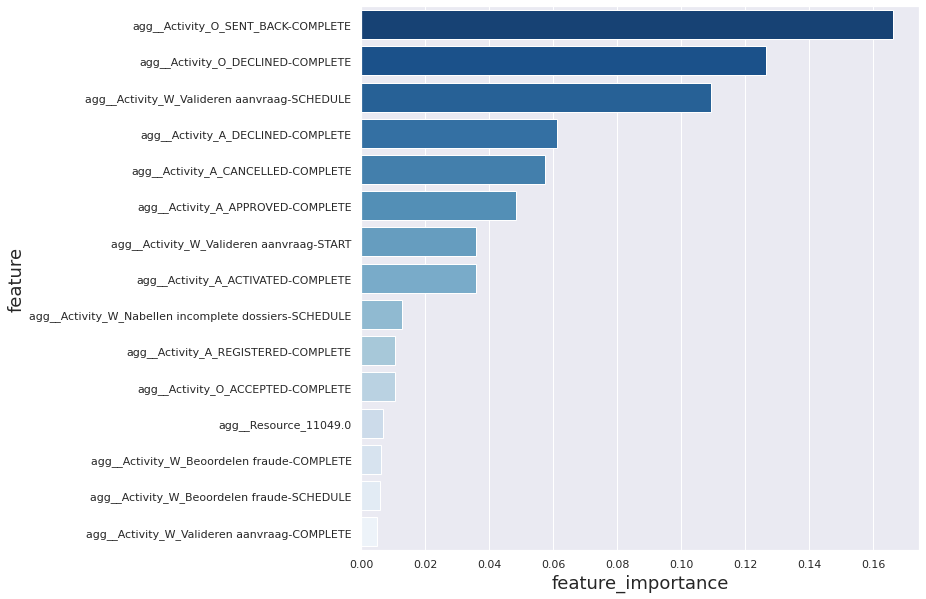

In [ ]:
sample_size = 500


In [ ]:
tn = pd.DataFrame.from_records(tn_list)
tn

,actual,caseID,input,nr_events,pred_type,predicted,proba
0,0,204466_10,AMOUNT_REQ Act...,10,TN,0,0.704813
1,0,204466_11,AMOUNT_REQ Act...,11,TN,0,0.681847
2,0,204466_12,AMOUNT_REQ Act...,12,TN,0,0.791169
3,0,204466_13,AMOUNT_REQ Act...,13,TN,0,0.785526
4,0,204466_14,AMOUNT_REQ Act...,14,TN,0,0.815659
5,0,204466_15,AMOUNT_REQ Act...,15,TN,0,0.838869
6,0,204466_16,AMOUNT_REQ Act...,16,TN,0,0.891994
7,0,204466_17,AMOUNT_REQ Act...,17,TN,0,0.894818
8,0,204466_18,AMOUNT_REQ Act...,18,TN,0,0.886054
9,0,204466_19,AMOUNT_REQ Act...,19,TN,0,0.875122


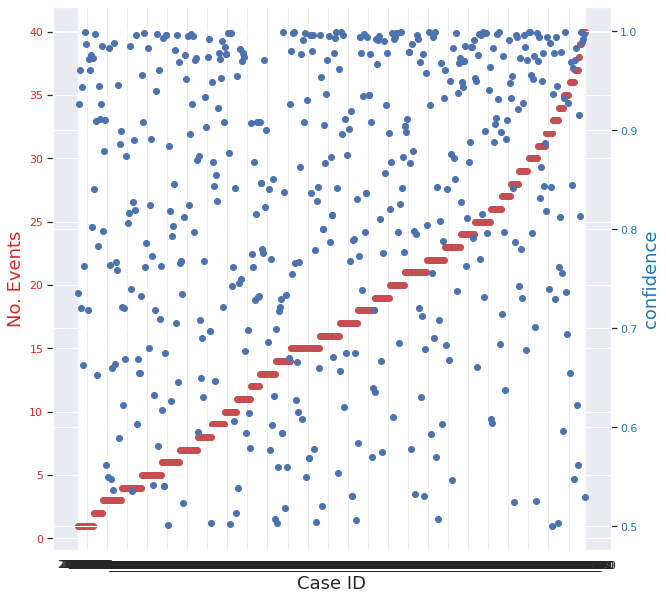

In [ ]:
x = tn_sample['caseID'].values
y1 = tn_sample['nr_events'].values
y2 = tn_sample['proba'].values

fig, ax1 = plt.subplots(figsize=(10, 10))

color = 'tab:red'
ax1.set_xlabel('Case ID')
ax1.set_ylabel('No. Events', color=color)
ax1.plot(x, y1, 'ro')
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2 = ax1.twinx()
ax2.set_ylabel('confidence', color=color)
ax2.plot(x, y2, 'bo')
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

In [ ]:
if group.shape[0] in [5,10,25] and (count_d<9 or count_r<9):
  print(group.shape,test_y_group[0], pred)
  test_x_group= feature_combiner.fit_transform(group) 
  test_x=np.transpose(test_x_group[0])
  print('Generating local Explanations for', dataset_manager.get_case_ids(group))
  exp=generate_local_explanations(explainer, test_x, cls, test_y_group )
  if(test_y_group[0]==1):
      count_d=count_d+1
      exp_dlist.append(exp)
else:
    count_r=count_r+1
    exp_rlist.append(exp)


NameError: ignored

In [ ]:
tn['caseID'].unique